In [ ]:
"""
对比有象区和无象区的LST差异，观察是否有降温效应
1.干旱期间LST差异，2015年 （仅在15-16年发生干旱区域，12-16年都没发生干旱区域）
2.干旱前LST差异，2012-2014年均值 （三年发生过一次以上干旱区域，三年未发生干旱区域）
"""

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from openpyxl import load_workbook
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import multiprocessing
import os
import time
import gloce as gc
from osgeo import gdal
from osgeo import gdalconst
from mpl_toolkits.basemap import Basemap
from glob import glob
from math import ceil
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
#return im_data, im_width, im_height, im_geotrans, im_proj
def read_img(filename):
    dt = gdal.Open(filename)
    im_width = dt.RasterXSize
    im_height = dt.RasterYSize
    im_bands = dt.RasterCount
    im_geotrans = dt.GetGeoTransform()
    im_proj = dt.GetProjection()
    im_data = dt.ReadAsArray(0,0,im_width,im_height)
    return im_data, im_width, im_height, im_geotrans, im_proj
def write_img(filename, im_proj, im_geotrans, im_data):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
spei_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/'
sm_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
soil_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
drv_path='//weili/User2/mxsun/CESS_230818/Pattern_drive/'
ele_path='//weili/User2/mxsun/CESS_230818/elephant_active_area/IUCN/'

# 干旱期间，15-16年

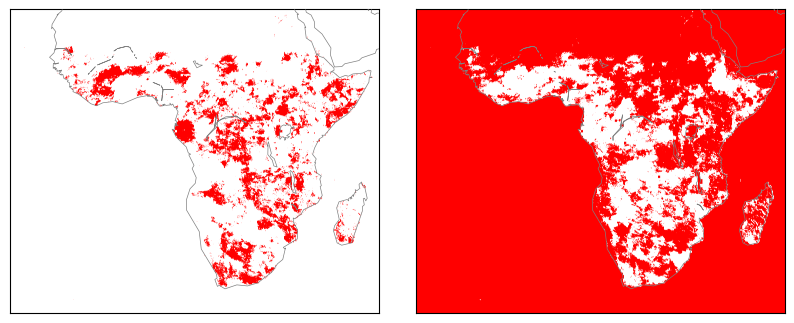

In [4]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
#SPEI,2012,2013,2014,2015,2016
drought=read_img(spei_path+'SPEI_drought_spei1516_001sub_240504.tif')[0]

spei_afr=read_img(spei_path+'SPEI_drought2012_16_001sub_240503.tif')[0]
spei_afr.shape
NDA=np.sum(spei_afr[3:5],0) #2015-2016年都没发生干旱的区域
NDA[NDA>0]=np.nan
NDA[NDA==0]=1
NDA[np.isnan(NDA)]=0

data=[drought,NDA]
plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
plt.rc('lines', linewidth = 1.5) 
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.2)
lon1 = -26;lon2 = 53
lat1 = -40;lat2 = 25
fig = plt.figure(figsize=(10,5)) ##width, height default(8,6)
plt.subplots_adjust(wspace=0.1,hspace=0.1)
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    m = Basemap(llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2)
    #m.drawmapboundary(linewidth=1,fill_color = 'lightcyan')
    m.drawcoastlines(linewidth=0.5, color='gray',zorder=40)
    clist=['white','red']
    cmp=LinearSegmentedColormap.from_list('chaos',clist)
    im = m.imshow(data[i],cmap =cmp,origin='upper')

In [5]:
drought.min()

0.0

In [6]:
"""
干旱年份2015年干旱和非干旱区域，有象&无象区域LST对比
2015 drought=drought, drought-elephant =:
    1 drought and non-elephant
    VS
    0 drought and elephant (or non-drought and non-elephant)
    -1 non-drought and elephant #remove
2015 non-drought=NDA, NDA - elephant =:
    1 non drought and non-elephant 
    VS
    0 non drought and elephant
    -1 drought and elephant #remove
"""
ele=read_img(ele_path+'fireCCI_eleIUCN20_LA-LCextant_mask001_230523.tif')[0]
ele[ele>0]=1
print(ele.min(),ele.max())
#提取干旱区域的有象区和无象区
dro_ele=drought*ele
dro_ele[dro_ele!=1]=np.nan
print(np.nanmin(dro_ele),np.nanmax(dro_ele))
dro_Nele=drought-ele
dro_Nele[dro_Nele<1]=np.nan
print(np.nanmin(dro_Nele),np.nanmax(dro_Nele))

#提取非干旱区的有象区和无象区
Ndro_Nele=NDA-ele
Ndro_Nele[Ndro_Nele<1]=np.nan
print(np.nanmin(Ndro_Nele),np.nanmax(Ndro_Nele))

Ndro_ele=NDA*ele
Ndro_ele[Ndro_ele!=1]=np.nan
print(np.nanmin(Ndro_ele),np.nanmax(Ndro_ele))

0 1
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


# 干旱前，2012-2014年 （三年发生过一次以上干旱区域，三年未发生干旱区域）

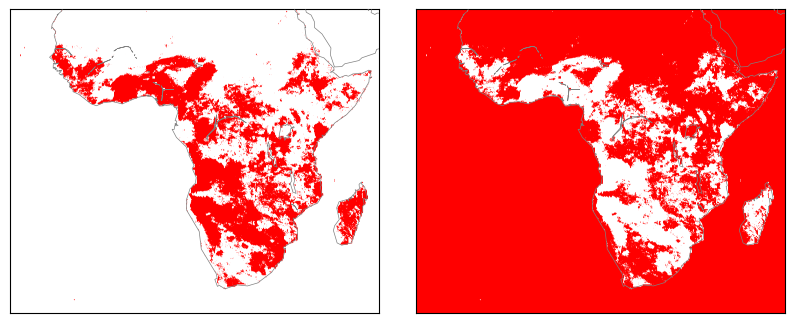

In [7]:
pre_drought=np.sum(spei_afr[0:3],0) #2012-2014年发生过一次以上干旱
pre_drought[pre_drought>0]=1

pre_NDA=np.sum(spei_afr[0:3],0)#2012-2014年从未发生过干旱
pre_NDA[pre_NDA>0]=np.nan
pre_NDA[pre_NDA==0]=1
pre_NDA[np.isnan(pre_NDA)]=0

data=[pre_drought,pre_NDA]
plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
plt.rc('lines', linewidth = 1.5)
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.2)
lon1 = -26;lon2 = 53
lat1 = -40;lat2 = 25
fig = plt.figure(figsize=(10,5)) ##width, height default(8,6)
plt.subplots_adjust(wspace=0.1,hspace=0.1)
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    m = Basemap(llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2)
    #m.drawmapboundary(linewidth=1,fill_color = 'lightcyan')
    m.drawcoastlines(linewidth=0.5, color='gray',zorder=40)
    clist=['white','red']
    cmp=LinearSegmentedColormap.from_list('chaos',clist)
    im = m.imshow(data[i],cmap =cmp,origin='upper')

In [8]:
"""
干旱前2012-2014年干旱和非干旱区域，有象&无象区域LST对比
2012-2014 drought=pre_drought, pre_drought-elephant =:
    1 drought and non-elephant
    VS
    0 drought and elephant
    -1 non-drought and elephant #remove    
2012-2014 non-drought=pre_NDA, pre_NDA - elephant =:
    1 non drought and non-elephant 
    VS
    0 non drought and elephant
    -1 drought and elephant #remove
"""
#提取干旱区域的有象区和无象区
pre_dro_ele=pre_drought*ele
pre_dro_ele[pre_dro_ele!=1]=np.nan
print(np.nanmin(pre_dro_ele),np.nanmax(pre_dro_ele))
pre_dro_Nele=pre_drought-ele
pre_dro_Nele[pre_dro_Nele<1]=np.nan
print(np.nanmin(pre_dro_Nele),np.nanmax(pre_dro_Nele))
#提取非干旱区的有象区和无象区
pre_Ndro_Nele=pre_NDA-ele
pre_Ndro_Nele[pre_Ndro_Nele<1]=np.nan
print(np.nanmin(pre_Ndro_Nele),np.nanmax(pre_Ndro_Nele))
pre_Ndro_ele=pre_NDA*ele
pre_Ndro_ele[pre_Ndro_ele!=1]=np.nan
print(np.nanmin(pre_Ndro_ele),np.nanmax(pre_Ndro_ele))

1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


# LST prepare

In [9]:
lst=read_img(spei_path+'lst_1516_afr_001.tif')[0]
lst=lst*0.02-273.15
lst_pre=read_img(spei_path+'MOD11_mean_2012-14_001.tif')[0]
lst_pre=lst_pre*0.02-273.15

# slide window

In [10]:
dem=read_img(spei_path+'gtopoDEM_afr_001.tif')[0]
slope=read_img(spei_path+'gtopoSlope_afr_001.tif')[0]
print('dem',dem.min(),dem.max())
print('slope',slope.min(),slope.max())

dem -9999 5438
slope -3.402823e+38 79.12291


In [11]:
#forest_mask=read_img(spei_path+'Africa_forest_area_240319.tif')[0]
hfp = read_img(spei_path+'hfp2018_Afirca_001_230525.tif')[0]
hfp[hfp<=15]=1
hfp[hfp>1]=np.nan
mask=hfp#forest_mask
mask[~np.isnan(mask)]=1
np.nanmin(mask),np.nanmax(mask)

(1.0, 1.0)

In [12]:
"""
supply paired sites methods. 
Be notes the  suppled detail locates should be consistence with all factors.
"""
# current shape:(6500,7900)
#0.01deg to 0.25 deg window size=625 pixels
#6500/25,7900/25...(260,316)
def slide_window_mean(s,dist,res):
    #s: window size
    #dist: disturb array
    #res: resistance and resilience array
    mean_arr=np.zeros((260,316))
    weight_arr=np.zeros((260,316))
    loc=np.zeros((260,316)) #record the location of supplied sites
    sl=np.ones((25,25))
    for i in range(260):
        #print("sliding", i, "line...")
        for j in range(316):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/625#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
                loc[i,j]=9
            else:
                bloc_dist_a=[] #should be 8 nums [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                res_dist_a=[] #should be 8 nums
                res_mask_pool=[]
                
                weight_pool=[]
                for m in [-1,1]:
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    bloc_dist_a.append(dist[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    res_dist_a.append(res[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                bloc_dist_a.append(dist[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                bloc_dist_a.append(dist[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                res_dist_a.append(res[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                res_dist_a.append(res[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                #the smooth order of a 9 value array is [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                for n in range(len(bloc_dist_a)): #the length is 8
                    res_mask_pool.append(np.multiply(bloc_dist_a[n],res_dist_a[n]))
                    weight_pool.append(np.count_nonzero(~np.isnan(res_mask_pool[n]))/625)#calculate the weight
                key=np.argmax(weight_pool) 
                # Key used to loc the supplied direction, the key-value consistience with [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                if weight_pool[key] > 0.05:
                    weight_arr[i,j]=weight_pool[key]
                    dt1=np.where(res_mask_pool[key]!=np.nan,res_mask_pool[key],np.nan)
                    mean_arr[i,j]=np.nanmean(dt1)#calculate the mean value
                    loc[i,j]=key+1
                else:
                    mean_arr[i,j]=np.nan#calculate the mean value
                    loc[i,j]=np.nan
    return mean_arr,loc

"""
2015-16年
dro15_ele,dro_Nele
dro16_ele,dro_Nele
Ndro_Nele,Ndro_ele
2012-2014年
pre_dro_ele,pre_dro_Nele
pre_Ndro_Nele,pre_Ndro_ele
"""
dist_pool1=[dro_ele*mask,dro_Nele*mask] #2015 drought,[elephant,non-elephant] ###use lst15 ###简写d15
dist_pool3=[Ndro_ele*mask,Ndro_Nele*mask] #2015-16 non-drought,[elephant,non-elephant] ###use lst15-16 均值 ###简写nd
dist_pool4=[pre_dro_ele*mask,pre_dro_Nele*mask] #2012-2014 drought, [elephant, non-elephant] ###use lst12-14 ###简写pd
dist_pool5=[pre_Ndro_ele*mask,pre_Ndro_Nele*mask] #2012-2014 non-drought, [elephant, non-elephant] ###use lst12-14 ###简写pnd
dist_pool=[dist_pool1,dist_pool3,dist_pool4,dist_pool5]

dist_name1=['dro_ele','dro_Nele']
dist_name3=['Ndro_ele','Ndro_Nele']
dist_name4=['pre_dro_ele','pre_dro_Nele']
dist_name5=['pre_Ndro_ele','pre_Ndro_Nele']
dist_name=[dist_name1,dist_name3,dist_name4,dist_name5]

lst_t=[lst,lst,lst_pre,lst_pre]
res_name=['lst','lst','lst_pre','lst_pre']

geo=[dem,slope]
geo_name=['dem','slope']


aa=[]
aa_name=[]
for i in range(4):
    for j in range(2):
        el=[25,dist_pool[i][j],lst_t[i]]
        aa.append(el)
        aa_name.append('Cooling_{}_{}_0.25deg_240505.npy'.format(dist_name[i][j],res_name[i]))
        
gg=[]
gg_name=[]
for i in range(4):
    for j in range(2):
        for k in range(2):
            el=[25,dist_pool[i][j],geo[k]]
            gg.append(el)
            gg_name.append('Cooling_{}_{}_0.25deg_240505.npy'.format(dist_name[i][j],geo_name[k]))
              
print(aa_name)

['Cooling_dro_ele_lst_0.25deg_240505.npy', 'Cooling_dro_Nele_lst_0.25deg_240505.npy', 'Cooling_Ndro_ele_lst_0.25deg_240505.npy', 'Cooling_Ndro_Nele_lst_0.25deg_240505.npy', 'Cooling_pre_dro_ele_lst_pre_0.25deg_240505.npy', 'Cooling_pre_dro_Nele_lst_pre_0.25deg_240505.npy', 'Cooling_pre_Ndro_ele_lst_pre_0.25deg_240505.npy', 'Cooling_pre_Ndro_Nele_lst_pre_0.25deg_240505.npy']


In [15]:
len(aa_name),len(gg_name)

(8, 16)

In [16]:
for i in range(8):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(aa[i][0],aa[i][1],aa[i][2])
    np.save(spei_path+aa_name[i],kk)

执行任务0 (41064)...
执行任务1 (41064)...
执行任务2 (41064)...
执行任务3 (41064)...
执行任务4 (41064)...
执行任务5 (41064)...
执行任务6 (41064)...
执行任务7 (41064)...


In [17]:
#计算geo的paired sites
for i in range(16):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(gg[i][0],gg[i][1],gg[i][2])
    np.save(spei_path+gg_name[i],kk)

执行任务0 (41064)...
执行任务1 (41064)...
执行任务2 (41064)...
执行任务3 (41064)...
执行任务4 (41064)...
执行任务5 (41064)...
执行任务6 (41064)...
执行任务7 (41064)...


C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


执行任务8 (41064)...
执行任务9 (41064)...
执行任务10 (41064)...
执行任务11 (41064)...
执行任务12 (41064)...
执行任务13 (41064)...
执行任务14 (41064)...
执行任务15 (41064)...


# 成对样点求Δ

In [13]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

def mask_geo(dem1,dem2,slo1,slo2):
    #创建地形控制，限制pired size两边地形差异
    #dem<200
    #slope<10
    dem_differ=dem1-dem2
    slo_differ=slo1-slo2
    dem_differ[dem_differ<-200]=np.nan
    dem_differ[dem_differ>200]=np.nan
    dem_differ[~np.isnan(dem_differ)]=1
    slo_differ[slo_differ<-10]=np.nan
    slo_differ[slo_differ>10]=np.nan
    slo_differ[~np.isnan(slo_differ)]=1
    # 每一层数据位置对应,建立mask
    dd_mask=np.ones((260,316))*dem_differ*slo_differ
    return dd_mask

dist_name1=['dro_ele','dro_Nele']
dist_name3=['Ndro_ele','Ndro_Nele']
dist_name4=['pre_dro_ele','pre_dro_Nele']
dist_name5=['pre_Ndro_ele','pre_Ndro_Nele']
geo_mask=[]
for i in range(4):
    dem1=np.load(spei_path+'Cooling_{}_{}_0.25deg_240505.npy'.format(dist_name[i][0],geo_name[0]),allow_pickle=True)[0]
    dem2=np.load(spei_path+'Cooling_{}_{}_0.25deg_240505.npy'.format(dist_name[i][1],geo_name[0]),allow_pickle=True)[0]
    slo1=np.load(spei_path+'Cooling_{}_{}_0.25deg_240505.npy'.format(dist_name[i][0],geo_name[1]),allow_pickle=True)[0]
    slo2=np.load(spei_path+'Cooling_{}_{}_0.25deg_240505.npy'.format(dist_name[i][1],geo_name[1]),allow_pickle=True)[0]
    geo_mask.append(mask_geo(dem1,dem2,slo1,slo2))

In [14]:
#——————————2015，2016年——————————
#干旱区域成对样点
lst_dro_ele=np.load(spei_path+'Cooling_dro_ele_lst_0.25deg_240505.npy',allow_pickle=True)[0]
lst_dro_Nele=np.load(spei_path+'Cooling_dro_Nele_lst_0.25deg_240505.npy',allow_pickle=True)[0]
delta_dro=(lst_dro_ele-lst_dro_Nele)*geo_mask[0]
delta_dro=kill_nan(delta_dro)

#非干旱区域成对样点
lst_Ndro_ele=np.load(spei_path+'Cooling_Ndro_ele_lst_0.25deg_240505.npy',allow_pickle=True)[0]
lst_Ndro_Nele=np.load(spei_path+'Cooling_Ndro_Nele_lst_0.25deg_240505.npy',allow_pickle=True)[0]
delta_Ndro_15=(lst_Ndro_ele-lst_Ndro_Nele)*geo_mask[1]
delta_Ndro_15=kill_nan(delta_Ndro_15)

#——————————2012-14年——————————
#干旱区域成对样点
lst_pre_dro_ele=np.load(spei_path+'Cooling_pre_dro_ele_lst_pre_0.25deg_240505.npy',allow_pickle=True)[0]
lst_pre_dro_Nele=np.load(spei_path+'Cooling_pre_dro_Nele_lst_pre_0.25deg_240505.npy',allow_pickle=True)[0]
delta_dro_1214=(lst_pre_dro_ele-lst_pre_dro_Nele)*geo_mask[2]
delta_dro_1214=kill_nan(delta_dro_1214)
#非干旱区域成对样点
lst_pre_Ndro_ele=np.load(spei_path+'Cooling_pre_Ndro_ele_lst_pre_0.25deg_240505.npy',allow_pickle=True)[0]
lst_pre_Ndro_Nele=np.load(spei_path+'Cooling_pre_Ndro_Nele_lst_pre_0.25deg_240505.npy',allow_pickle=True)[0]
delta_Ndro_1214=(lst_pre_Ndro_ele-lst_pre_Ndro_Nele)*geo_mask[3]
delta_Ndro_1214=kill_nan(delta_Ndro_1214)

In [15]:
len(delta_dro),len(delta_Ndro_15),len(delta_dro_1214),len(delta_Ndro_1214)

(2947, 4214, 4831, 4397)

In [16]:
np.mean(delta_dro),np.mean(delta_Ndro_15),np.mean(delta_dro_1214),np.mean(delta_Ndro_1214)

(-0.2389063471084455,
 -0.2224971054287165,
 -0.2454558981801247,
 -0.24810912119298112)

In [17]:
#标准误
stats.sem(delta_dro),stats.sem(delta_Ndro_15),stats.sem(delta_dro_1214),stats.sem(delta_Ndro_1214)

(0.02428359360735992,
 0.02320040412758558,
 0.019479706679520002,
 0.02077718581791206)

# Fig

## significants

In [18]:
def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

#——————————2015,2016年——————————
#干旱区域成对样点
lst_dro_ele=np.load(spei_path+'Cooling_dro_ele_lst_0.25deg_240505.npy',allow_pickle=True)[0]
lst_dro_Nele=np.load(spei_path+'Cooling_dro_Nele_lst_0.25deg_240505.npy',allow_pickle=True)[0]
ddt=del_nan(lst_dro_ele,lst_dro_Nele)
sta,p_delta_dro=stats.wilcoxon(ddt[0],ddt[1])
#非干旱区域成对样点
lst_Ndro_ele=np.load(spei_path+'Cooling_Ndro_ele_lst_0.25deg_240505.npy',allow_pickle=True)[0]
lst_Ndro_Nele=np.load(spei_path+'Cooling_Ndro_Nele_lst_0.25deg_240505.npy',allow_pickle=True)[0]
ddt1=del_nan(lst_Ndro_ele,lst_Ndro_Nele)
sta,p_delta_Ndro_15=stats.wilcoxon(ddt1[0],ddt1[1])

#——————————2012-14年——————————
#干旱区域成对样点
lst_pre_dro_ele=np.load(spei_path+'Cooling_pre_dro_ele_lst_pre_0.25deg_240505.npy',allow_pickle=True)[0]
lst_pre_dro_Nele=np.load(spei_path+'Cooling_pre_dro_Nele_lst_pre_0.25deg_240505.npy',allow_pickle=True)[0]
ddt2=del_nan(lst_pre_dro_ele,lst_pre_dro_Nele)
sta,p_delta_dro_1214=stats.wilcoxon(ddt2[0],ddt2[1])
#非干旱区域成对样点
lst_pre_Ndro_ele=np.load(spei_path+'Cooling_pre_Ndro_ele_lst_pre_0.25deg_240505.npy',allow_pickle=True)[0]
lst_pre_Ndro_Nele=np.load(spei_path+'Cooling_pre_Ndro_Nele_lst_pre_0.25deg_240505.npy',allow_pickle=True)[0]
ddt3=del_nan(lst_pre_Ndro_ele,lst_pre_Ndro_Nele)
sta,p_delta_Ndro_1214=stats.wilcoxon(ddt3[0],ddt3[1])

p_delta_dro,p_delta_Ndro_15,p_delta_dro_1214,p_delta_Ndro_1214 #p value of ndvi_res and csif_res

(4.3587635467228536e-11,
 1.9273767041356738e-11,
 3.488185721774791e-16,
 2.2886827793621244e-17)

## fig pdf

In [19]:
df_delta_15=[delta_dro,delta_Ndro_15]
df_delta_1214=[delta_dro_1214,delta_Ndro_1214]
df_delta=[df_delta_15,df_delta_1214]

-0.2389063471084455 [0.45470379]
-0.2224971054287165 [0.40778951]
-0.2454558981801247 [0.44480953]
-0.24810912119298112 [0.44395003]


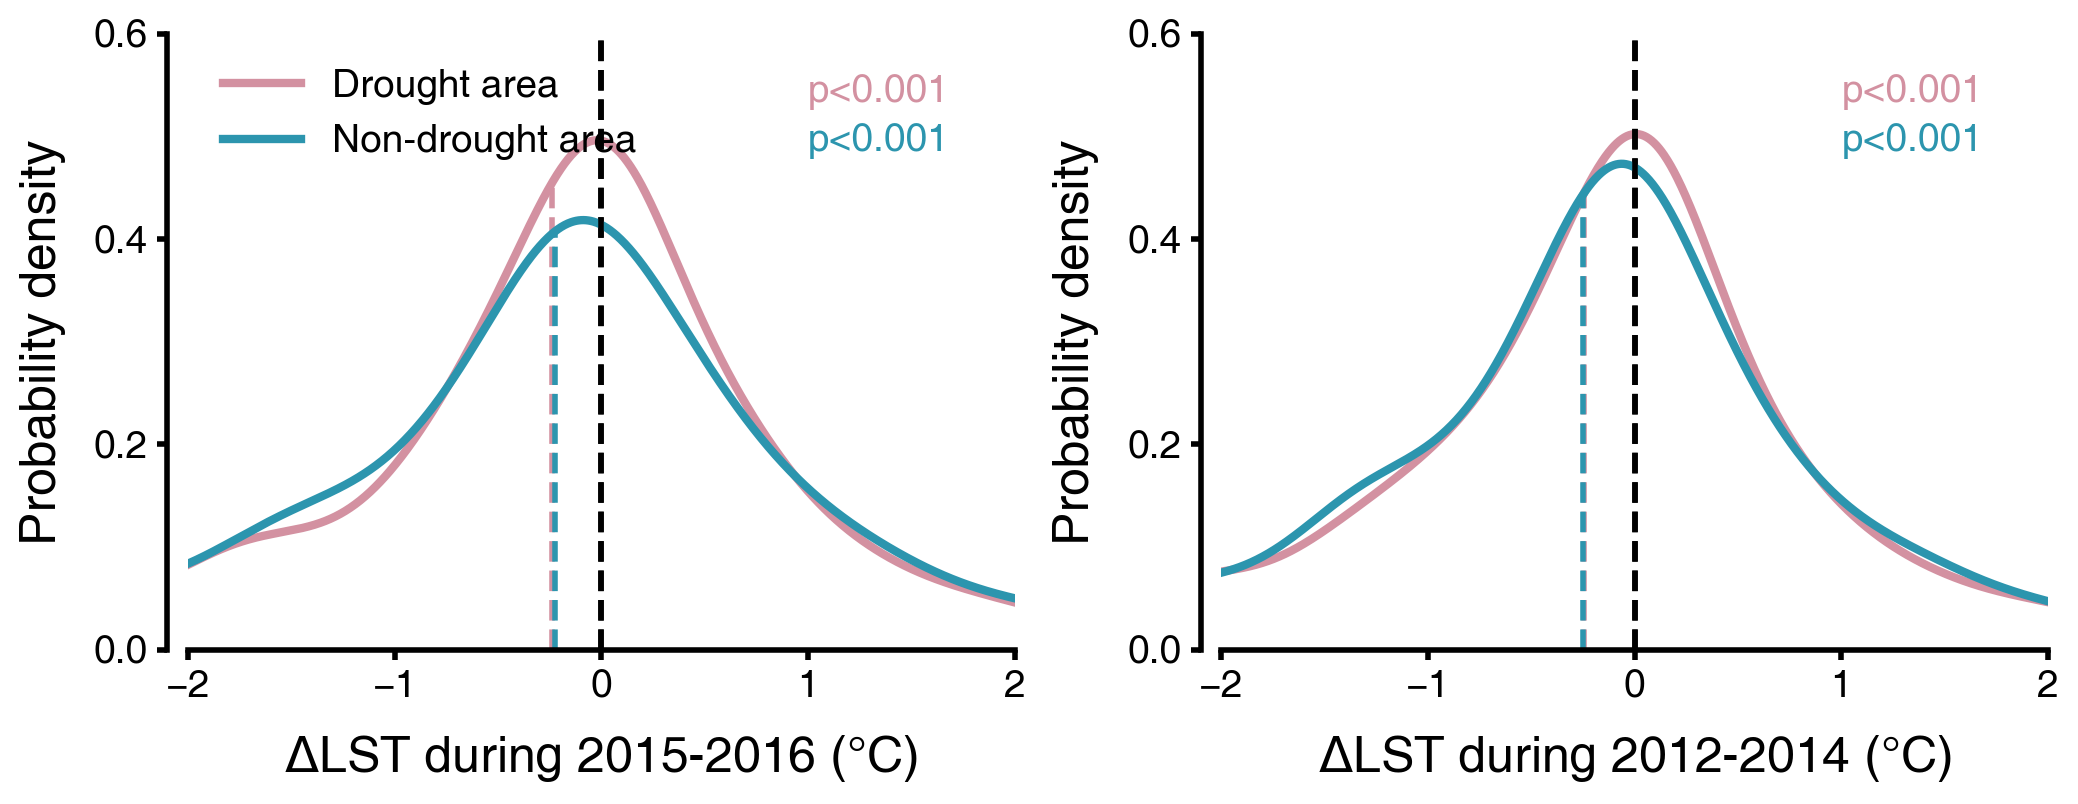

In [20]:
#-*- coding:utf-8 –*-
import gloce as gc
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(12,4)) ##width, height default(8,6)
plt.subplots_adjust(wspace=0.25,hspace=0.02)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 14}
plt.rc('font', **font)  # pass in the font dict as kwargs
#pp=[p_delta_LA[1],p_delta_LA[0]]
#pp1=[p_delta_LC[1],p_delta_LC[0]]
cl1= np.array([(211,145,161),(44,149,174)])
cl2= np.array([(231,195,204),(115,200,219)])
cl=[cl1/255,cl2/255]
#cl2=['C0','salmon']
label1=['Drought area','Non-drought area']
label2=['Drought area','Non-drought area']
label=[label1,label2]
#colors = ['coral','yellowgreen','green','orange']
#lc3 = ['NF_BB','F_BB','F_NBB','NF_NBB']
#fig, axs=plt.subplots(2,2,sharex=True,sharey=True)
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    for j in range(2):
        x=np.linspace(-2,2,1000)
        mean=np.nanmean(df_delta[i][j])
        delta_rav=gc.nanravel(df_delta[i][j])
        kenal=gaussian_kde(delta_rav)
        z=kenal.evaluate(x)
        z_mean=kenal.evaluate(mean)
        print(mean,z_mean)
        ax.plot(x,z,lw=3,color=cl[0][j],label=label[i][j])
        ax.vlines(mean,0,z_mean,lw=2,ls='--',color=cl[0][j])
        ax.vlines(0,0,0.8,lw=2,ls='--',color='black')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
        if i==0:
            ax.legend(fontsize=14,loc='upper left',frameon=False)
            if j==1:
                #ax.text(0.75,0.89-j*0.09, '{:.2f} **'.format(mean), fontsize=16,transform = ax.transAxes,color=cl[0][j])
                ax.text(0.75,0.89-j*0.08, 'p<0.001', fontsize=14,transform = ax.transAxes,color=cl[0][j])
            else:
                #ax.text(0.75,0.89-j*0.09, '{:.2f} ***'.format(mean), fontsize=16,transform = ax.transAxes,color=cl[0][j])
                ax.text(0.75,0.89-j*0.08, 'p<0.001', fontsize=14,transform = ax.transAxes,color=cl[0][j])
        if i==1:
            if j==0:
                #ax.text(0.75,0.89-j*0.09, '{:.2f} (p=0.06)'.format(mean), fontsize=14,transform = ax.transAxes,color=cl[0][j])
                ax.text(0.75,0.89-j*0.08, 'p<0.001', fontsize=14,transform = ax.transAxes,color=cl[0][j])
            else:
                #ax.text(0.75,0.89-j*0.09, '{:.2f} ***'.format(mean), fontsize=16,transform = ax.transAxes,color=cl[0][j])
                ax.text(0.75,0.89-j*0.08, 'p<0.001', fontsize=14,transform = ax.transAxes,color=cl[0][j])
        if i ==0:
            ax.set_xlabel('$\Delta$LST during 2015-2016 (°C)',labelpad=10)
        else:
            ax.set_xlabel('$\Delta$LST during 2012-2014 (°C)',labelpad=10)

    #ax.text(-0.15,1, '(c)', transform = ax.transAxes,color='black',fontsize=20)
    ax=plt.gca()
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',-2.1))
    ax.set_ylim(0,0.6)
    ax.set_xlim(-2,2)
    ax.set_xticks(np.arange(-2,2.01,1))
    ax.set_yticks(np.arange(0,0.601,0.2))
    ax.set_ylabel('Probability density',labelpad=10)
    
    ax.tick_params(labelsize=14)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    #rect = ax.patch
    #rect.set_facecolor((202/255,233/255,246/255))
#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/Fig2_a-b.tif", dpi=600, bbox_inches = 'tight')

In [21]:
#df_delta_15=[delta_dro,delta_Ndro_15]
#df_delta_1214=[delta_dro_1214,delta_Ndro_1214]
df_delta1=[delta_dro,delta_dro_1214]

-0.2389063471084455 [0.45470379]
-0.2454558981801247 [0.44480953]


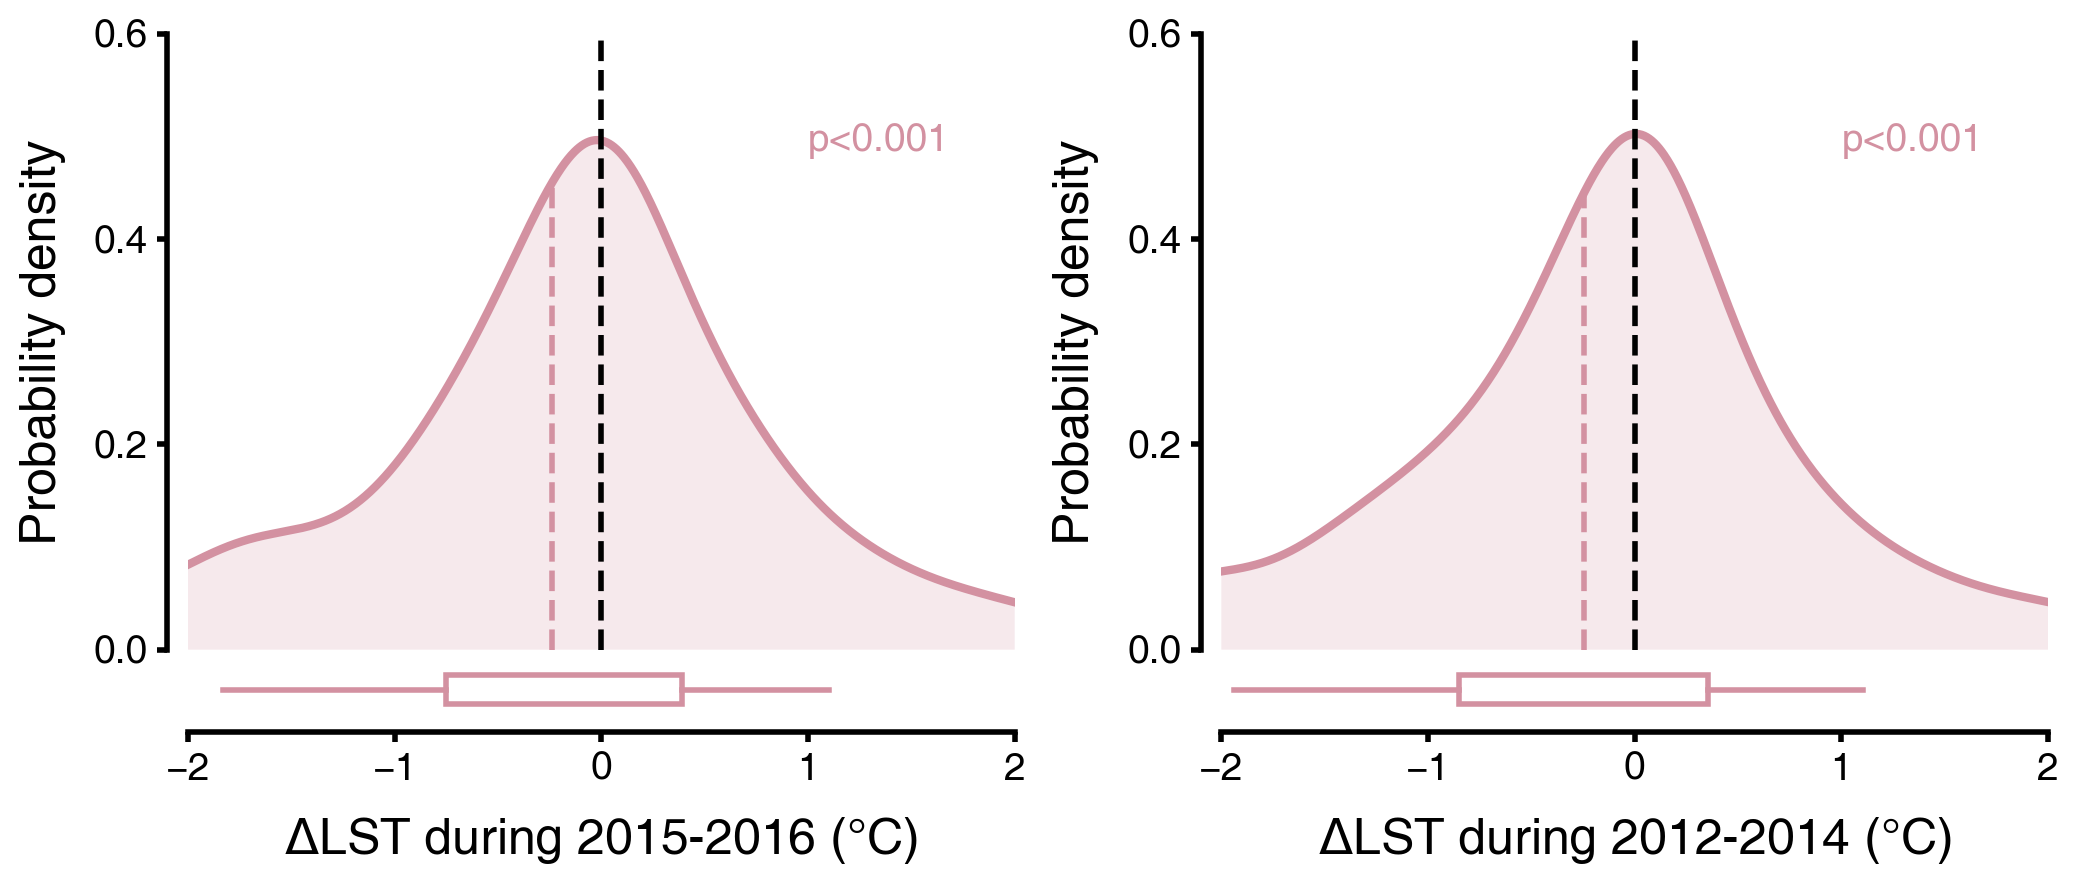

In [27]:
#-*- coding:utf-8 –*-
import gloce as gc
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(12,4)) ##width, height default(8,6)
plt.subplots_adjust(wspace=0.25,hspace=0.02)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 14}
plt.rc('font', **font)  # pass in the font dict as kwargs
#pp=[p_delta_LA[1],p_delta_LA[0]]
#pp1=[p_delta_LC[1],p_delta_LC[0]]
cl1= np.array([(211,145,161)])
cl2= np.array([(231,195,204)])
cl=[cl1/255,cl1/255]
#cl2=['C0','salmon']
label1=['Drought area']
label2=['Drought area']
label=[label1,label2]
#colors = ['coral','yellowgreen','green','orange']
#lc3 = ['NF_BB','F_BB','F_NBB','NF_NBB']
#fig, axs=plt.subplots(2,2,sharex=True,sharey=True)
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    x=np.linspace(-2,2,1000)
    mean=np.nanmean(df_delta1[i])
    delta_rav=gc.nanravel(df_delta1[i])
    kenal=gaussian_kde(delta_rav)
    z=kenal.evaluate(x)
    z_mean=kenal.evaluate(mean)
    print(mean,z_mean)
    ax.plot(x,z,lw=3,color=cl[0],label=label[i])
    ax.fill_between(x,0,z,facecolor=cl[i],alpha=0.2)
    ax.vlines(mean,0,z_mean,lw=2,ls='--',color=cl[0])
    ax.vlines(0,0,0.8,lw=2,ls='--',color='black')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    if i==0:
        #ax.legend(fontsize=14,loc='upper left',frameon=False)
        if j==1:
            #ax.text(0.75,0.89-j*0.09, '{:.2f} **'.format(mean), fontsize=16,transform = ax.transAxes,color=cl[0][j])
            ax.text(0.75,0.89-j*0.08, 'p<0.001', fontsize=14,transform = ax.transAxes,color=cl[0])
        else:
            #ax.text(0.75,0.89-j*0.09, '{:.2f} ***'.format(mean), fontsize=16,transform = ax.transAxes,color=cl[0][j])
            ax.text(0.75,0.89-j*0.08, 'p<0.001', fontsize=14,transform = ax.transAxes,color=cl[0])
    if i==1:
        if j==0:
            #ax.text(0.75,0.89-j*0.09, '{:.2f} (p=0.06)'.format(mean), fontsize=14,transform = ax.transAxes,color=cl[0][j])
            ax.text(0.75,0.89-j*0.08, 'p<0.001', fontsize=14,transform = ax.transAxes,color=cl[0])
        else:
            #ax.text(0.75,0.89-j*0.09, '{:.2f} ***'.format(mean), fontsize=16,transform = ax.transAxes,color=cl[0][j])
            ax.text(0.75,0.89-j*0.08, 'p<0.001', fontsize=14,transform = ax.transAxes,color=cl[0])
    if i ==0:
        ax.set_xlabel('$\Delta$LST during 2015-2016 (°C)',labelpad=10)
    else:
        ax.set_xlabel('$\Delta$LST during 2012-2014 (°C)',labelpad=10)

    #ax.text(-0.15,1, '(c)', transform = ax.transAxes,color='black',fontsize=20)
    ax=plt.gca()
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',-2.1))
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',-0.08))
    ax.set_ylim(0,0.6)
    ax.set_xlim(-2,2)
    ax.set_xticks(np.arange(-2,2.01,1))
    ax.set_yticks(np.arange(0,0.601,0.2))
    ax.set_ylabel('Probability density',labelpad=10)

    ax.tick_params(labelsize=14)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    #添加箱线图----------------------------
    if i ==0:
        ax1=fig.add_axes([0.122,-0,0.35,0.12])#左，底，宽，高
        ax1.set_xlim(-2,2)
        ax1.set_xticks(np.arange(-2,2.01,1))
        ax1.axis('off')
    else:
        ax1=fig.add_axes([0.55,-0,0.35,0.12])#左，底，宽，高
        ax1.set_xlim(-2,2)
        ax1.set_xticks(np.arange(-2,2.01,1))
        ax1.axis('off')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.tick_params(bottom=False,top=False, left=False, right=False)#隐藏刻度线
    #ax.spines['bottom'].set_visible(False)
    bplot=ax1.boxplot(df_delta1[i],
                      vert=False,
                      whis=(10,90),                
                      widths=0.3,
                      patch_artist=True,
                      showmeans=False,
                      meanprops = {'marker':'o','markerfacecolor':cl[i],"markeredgecolor":cl[i],"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                      medianprops={'linewidth':'0.5',"color":cl[i],"alpha":0},
                      boxprops={"facecolor": 'none', "edgecolor": cl[i],"linewidth":2,"alpha":1},
                      capprops=None,
                      whiskerprops={'linewidth':'2','color':cl[i]},
                      showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示；
                      showfliers = False,
                      flierprops = {'marker':'+','markersize':'3','markeredgecolor':cl[i],'color':cl[i]})
    #rect = ax.patch
    #rect.set_facecolor((202/255,233/255,246/255))
#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/Fig2_a-b.tif", dpi=600, bbox_inches = 'tight')